# 프로젝트 : 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# hyperparameter
BATCH_SIZE = 16
EPOCHS = 25

## Step 2. 데이터 준비하기
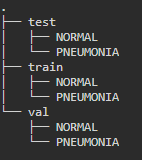

``tf.io.gfile.glob`` : 주어진 패턴과 일치하는 파일 목록을 반환

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

5216
16
624


In [5]:
# val 데이터 부족해서 train에서 더 가져온다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train 데이터, val 데이터 모아서 8:2로 나누자
# train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
train_size = math.floor(len(filenames)*0.8) # math.floor : 내림
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 2.1 train_filenames에서 정상이미지, 폐렴 이미지 갯수는?
파일 경로에 ``Normal`` 있으면 - 정상 이미지 <br>
파일 경로에 ``PNEUMONIA`` 있으면 - 폐렴 이미지

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename]) 
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


폐렴 이미지가 정상 이미지보다 3배나 더 많다. -> 데이터 imbalance(불균형) <br>
**차후에 조정!!!**

### 2.2 Train 데이터셋, validation 데이터셋 만들기
``tf.data.experimental.cardinality`` : 특정 데이터 집합의 유니크(Unique)한 값의 개수 리턴

In [7]:
# Train 데이터셋, validation 데이터셋 개수 확인
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # 특정 데이터 집합의 유니크(Unique)한 값의 개수 리턴
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 2.2.1 라벨 데이터를 만들어 주는 함수 만들기
현재 이미지에는 라벨 데이터 X  <br>
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수 만들어보자

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분 가능
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(True), 노말이면 음성(False)

#### 2.2.2 이미지 사이즈 통일 함수 & 이미지, 라벨 읽어오는 함수 만들기
이미지 데이터의 사이즈 제각각일수 있음.
이미즈 사이즈 통일 필요

In [9]:
# 이미지 사이즈 통일 시키는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img,channels=3) # 이미지 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img,IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일 경로 입력하면 이미지, 라벨 읽어오는 함수 
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지 사이즈 통일 함수 사용
    return img, label

#### 2.2.3 AUTOTUNE 변수 이용해서 train, val 데이터 셋 만들기
AUTOTUNE 변수 이용 -> 데이터 빠르게 처리 가능 

``tf.data.experimental.AUTOTUNE`` : 어떤 수준의 병렬처리가 tf.data 런타임에 사용되는지에 대해 결정 

train_list_ds.map 안에 ``num_parallel_calls`` 인수 무슨 의미? : map 변환은 병렬 처리 레벨을 지정하기 위해 num_parallel_calls 인수를 제공

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
print(train_ds)
print(val_ds)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


In [12]:
# 1개 데이터 가져와서 이미지, 라벨 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### 2.3 Test 데이터셋 만들기

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2.4 Data augmentation로 데이터 보충
- 좌우 반전 augmentation 도입

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우 반전
    return image, label

### 2.5 prepare_for_training() 함수를 정의해서 데이터를 변환
- 위에서 만든 ``augment`` 함수 적용
- tf.data 파이프 라인 이용
- ``shuffle()``을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- ``repeat()``를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용 가능 
- ``batch()``를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐 
- ``prefetch()``를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄이기 가능

In [15]:
# augment 함수 적용 전 함수
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

n_train_ds = prepare_for_training(train_ds)
n_val_ds = prepare_for_training(val_ds)

In [16]:
print(train_ds)
print(val_ds)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


In [17]:
# augment 함수 적용 후 함수
def aug_prepare_for_training(ds, shuffle_buffer_size=1000):
    df = ds.map(augment, num_parallel_calls=2) # 병렬 처리 레벨 2
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

aug_train_ds = aug_prepare_for_training(train_ds)
aug_val_ds = aug_prepare_for_training(val_ds)

#### 데이터 증강 후 개수 확인 어떻게 하는가?

## Step 3. 데이터 시각화


- train에 있는 batch 중 첫 번째 배치를 추출
-  추출된 배치를 image와 label 데이터 셋으로 나눈다
- ``show_batch()`` 함수를 이용해서 결과 사진을 출력해보기


``math.ceil()`` : 올림<br>
``next(iter())``: iter()함수로 생성한 iterato 객체 next()함수로 순서대로 값 가져옴

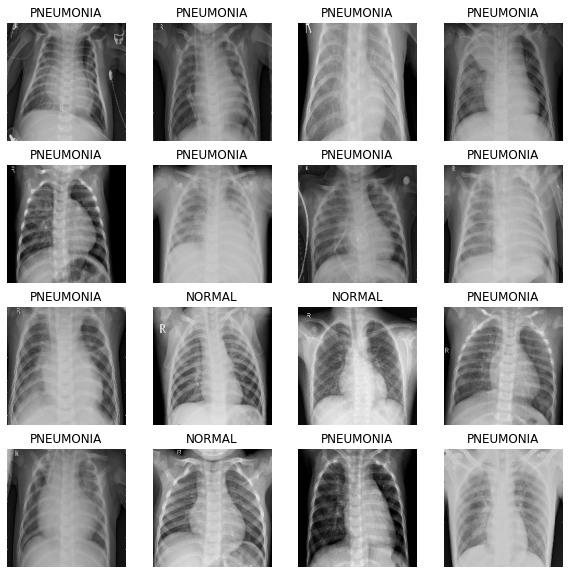

In [18]:
# show_batch : 이미지 배치를 입력하면 여러장의 이미지를 보여주는 함수 
# augment 적용 전
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4),n+1) # n+1 : 1부터 시작
        plt.imshow(image_batch[n])
        if label_batch[n]:  # 1,True 
            plt.title("PNEUMONIA")
        else: # 0, False
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(n_train_ds))
#image_batch, label_batch = next(iter(n_train_ds))
show_batch(image_batch.numpy(),label_batch.numpy())

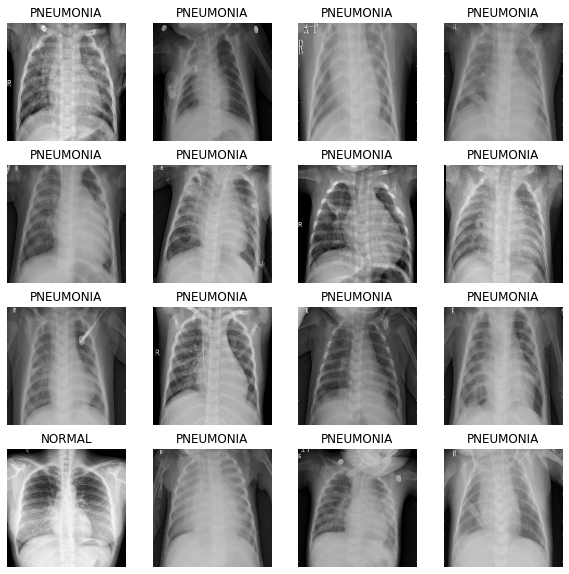

In [19]:
# show_batch : 이미지 배치를 입력하면 여러장의 이미지를 보여주는 함수 
# augment 적용 후 
def aug_show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(aug_train_ds))
aug_show_batch(image_batch.numpy(),label_batch.numpy())

## Step 4. CNN 모델링
1. BatchNormalization O, Dropout O
2. BatchNormalization X, Dropout 0
3. BatchNormalization O, Dropout X
4. filter, 채널 개수, activation, 모델 구조 변경
5. Drop rate 변경

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,3,activation='relu',padding="same"),
        tf.keras.layers.SeparableConv2D(filters,3,activation='relu',padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D() 
    ])
    return block

In [21]:
def dense_block(units,dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)),
        tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.2),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
        
    ])
    
    return model

check_model = build_model()
check_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fa54c3d6310>>

## Step 5. 데이터 imbalance 처리
데이터 불균형 Weight balancing 기술로 해결 가능

Weight balancing - training set의 각 데이터에서 loss 계산할 때 특정 클래스의 데이터에 더 큰 loss갖도록 가중치 부여

``weight_for_0`` : 'Normal' 이미지에 사용할 weight<br>
``weight_for_1`` : 'Pneumonia' 이미지에 사용할 weight<br>
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
이미지 훈련 - GPU 사용 <br>
``build_model()``로 모델 선언 <br>
이미지 라벨 2개 -> **"binary_crossentropy"** loss 사용 <br>
optimizer='adam' 사용<br>
성과 측정 metrics로 **'accuracy','precision','recall'**사용

In [24]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', #'adam'을 'rmspro'으로 바꿈
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [25]:
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 187ms/step - loss: 0.2387 - accuracy: 0.8875 - precision: 0.9755 - recall: 0.8706 - val_loss: 0.6146 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 186ms/step - loss: 0.1693 - accuracy: 0.9377 - precision: 0.9765 - recall: 0.9388 - val_loss: 1.3852 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1261 - accuracy: 0.9550 - precision: 0.9831 - recall: 0.9559 - val_loss: 0.6073 - val_accuracy: 0.7933 - val_precision: 0.7804 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1219 - accuracy: 0.9591 - precision: 0.9845 - recall: 0.9601 - val_loss: 1.2802 - val_accuracy: 0.6596 - val_precision: 1.0000 - val_recall: 0.5385
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.0920 - accura

## Step 7. 결과 확인과 시각화

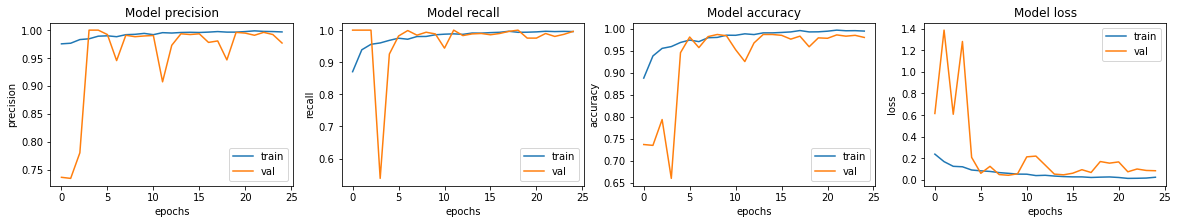

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 1.8884 - accuracy: 0.7484 - precision: 0.7130 - recall: 1.0000
Loss: 1.8883559703826904,
Accuracy: 0.7483974099159241,
Precision: 0.7129799127578735,
Recall: 1.0


## Step 8. 전이학습
DenseNet 사용해보기
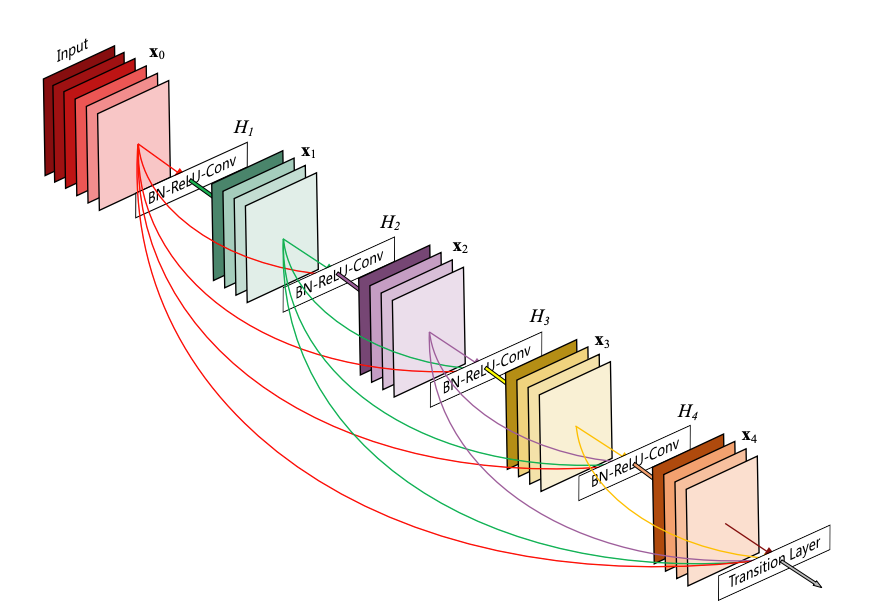

In [28]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 90, 90, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1/conv[0][0]                 
_______________________

In [29]:
layers = base_model.layers
print("레이어 개수: ",len(layers))

레이어 개수:  428


In [31]:
with tf.device('/GPU:0'):
    base_model = DenseNet121(include_top=False, weights='imagenet')
    
    x = base_model.output

    x = GlobalAveragePooling2D()(x)

    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=predictions)


    model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=METRICS
    )

In [30]:
# base_model = DenseNet121(include_top=False, weights='imagenet')
# x = base_model.output

# x = GlobalAveragePooling2D()(x)

# predictions = Dense(1, activation="sigmoid")(x)

# model = Model(inputs=base_model.input, outputs=predictions)


# model.compile(loss='binary_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'])

In [32]:
# 전이학습
with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 79s 229ms/step - loss: 0.1826 - accuracy: 0.9306 - precision: 0.9350 - recall: 0.9374 - val_loss: 0.1942 - val_accuracy: 0.9260 - val_precision: 1.0000 - val_recall: 0.8992
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.1178 - accuracy: 0.9545 - precision: 0.9873 - recall: 0.9510 - val_loss: 0.1447 - val_accuracy: 0.9404 - val_precision: 0.9835 - val_recall: 0.9346
Epoch 3/25
261/261 [==============================] - 58s 221ms/step - loss: 0.0796 - accuracy: 0.9703 - precision: 0.9918 - recall: 0.9681 - val_loss: 0.3663 - val_accuracy: 0.8625 - val_precision: 0.9984 - val_recall: 0.8141
Epoch 4/25
261/261 [==============================] - 58s 221ms/step - loss: 0.0723 - accuracy: 0.9715 - precision: 0.9931 - recall: 0.9684 - val_loss: 1.3045 - val_accuracy: 0.6663 - val_precision: 1.0000 - val_recall: 0.5452
Epoch 5/25
261/261 [==============================] - 58s 221ms/step - loss: 0.0646 - accura

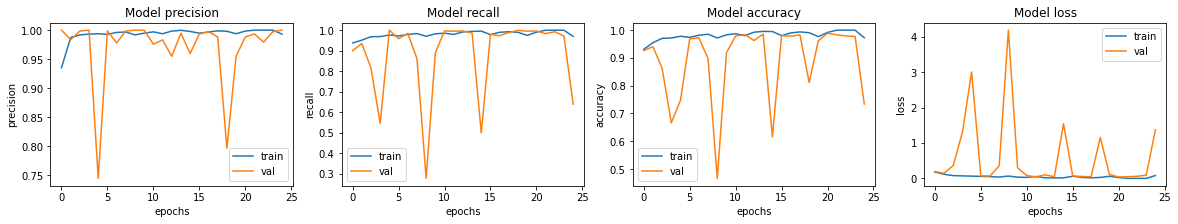

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 0.9301 - accuracy: 0.7853 - precision: 0.9885 - recall: 0.6641
Loss: 0.9301167726516724,
Accuracy: 0.7852563858032227,
Precision: 0.9885495901107788,
Recall: 0.6641025543212891


# 실험 결과
---

#### 1. BatchNormalization O, Dropout O - 정확도 82%
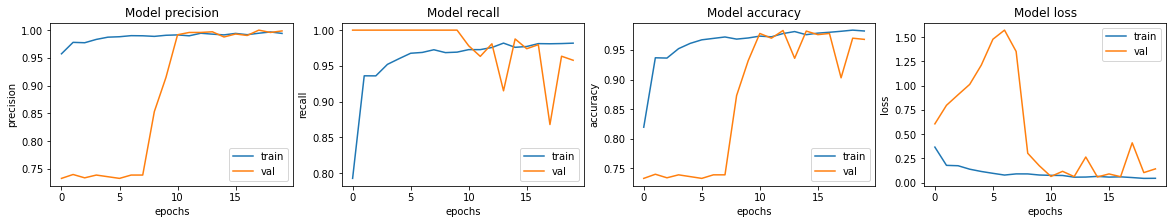 

Loss: 0.8088957667350769,

Accuracy: 0.8221153616905212,

Precision: 0.7852760553359985,

Recall: 0.9846153855323792

#### 2. BatchNormalization X, Dropout 0 ->  정확도 너무 내려갔다
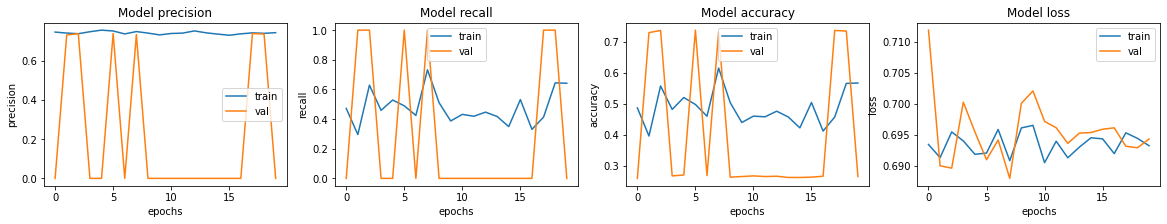

Loss: 0.6937667727470398, 

Accuracy: 0.375,

Precision: 0.0,

Recall: 0.0


#### 3. BatchNormalization O, Dropout X -> 정확도 83% 전보다 1%정도 올라감
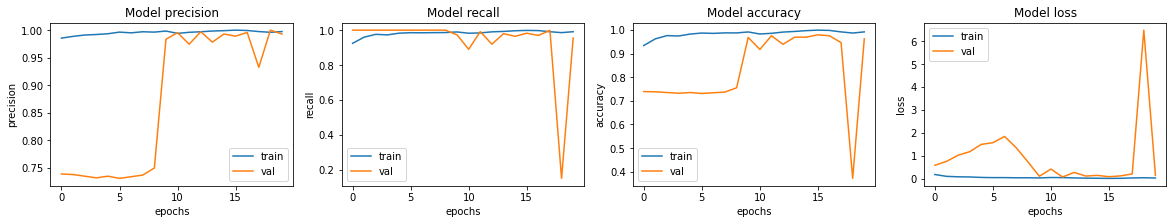

Loss: 0.9056073427200317,

Accuracy: 0.8317307829856873,

Precision: 0.7987421154975891,

Recall: 0.9769230484962463

#### 4. 모델 구조 변경(신경망 줄이기), optimizer= rmsprop으로 변경 -> loss값 증가, 정확도 더 떨어짐
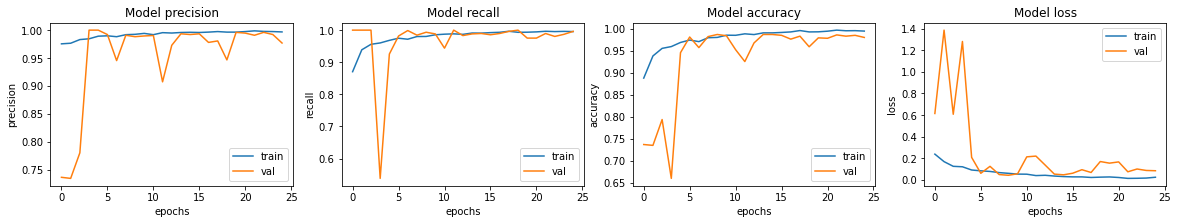

Loss: 1.8883559703826904,

Accuracy: 0.7483974099159241,

Precision: 0.7129799127578735,

Recall: 1.0

#### 5. Densenet 으로 전이학습 -> 정확도 78퍼 밖에 안나옴
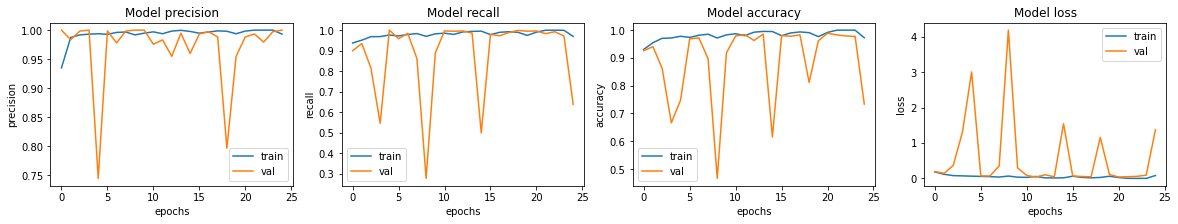

Loss: 0.9301167726516724,

Accuracy: 0.7852563858032227,

Precision: 0.9885495901107788,

Recall: 0.6641025543212891

## 회고
---
- 정확도 왜이렇게 안올라가지 데이터 증강 방법을 좀 바꿔봐야겠다
- 전이학습 모델도 Densenet 말고 다른 모델을 더 돌려보자
- loss 값이 근데 왜 1에 가까이 나오는지 이해가 안간다 이부분 더 찾아보자